In [1]:
pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [2]:
pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=e9f0292fc56a4ead1e9f525e4212b21a1699cb93caafc0112d9a96687ff5bea5
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go
from fpdf import FPDF
from geopy.distance import geodesic
import webbrowser

In [4]:
# Load dataset
data_path = 'UberDataExtracted.csv'
dataset = pd.read_csv(data_path)

In [11]:
dataset.shape

(722, 12)

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 722 entries, 23 to 1138
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   START_DATE         721 non-null    datetime64[ns]
 1   END_DATE           722 non-null    datetime64[ns]
 2   CATEGORY           722 non-null    object        
 3   START              722 non-null    object        
 4   STOP               722 non-null    object        
 5   MILES              722 non-null    float64       
 6   PURPOSE            722 non-null    object        
 7   DURATION_MINUTES   721 non-null    float64       
 8   DAY                721 non-null    object        
 9   MONTH              721 non-null    object        
 10  YEAR               721 non-null    float64       
 11  DISTANCE_CATEGORY  722 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(7)
memory usage: 73.3+ KB


In [5]:
# Parse START_DATE and END_DATE as datetime objects
dataset['START_DATE'] = pd.to_datetime(dataset['START_DATE'], format='%m/%d/%Y %H:%M', errors='coerce')
dataset['END_DATE'] = pd.to_datetime(dataset['END_DATE'], format='%m/%d/%Y %H:%M', errors='coerce')

In [6]:
# Fill missing values in CATEGORY and PURPOSE
dataset['CATEGORY'].fillna('Unknown', inplace=True)
dataset['PURPOSE'].fillna('Other', inplace=True)

<ipython-input-6-c315c890cc4a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['CATEGORY'].fillna('Unknown', inplace=True)
<ipython-input-6-c315c890cc4a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [7]:
# Drop rows with invalid END_DATE
dataset.dropna(subset=['END_DATE'], inplace=True)

In [8]:
# Calculate trip duration in minutes
dataset['DURATION_MINUTES'] = (dataset['END_DATE'] - dataset['START_DATE']).dt.total_seconds() / 60

In [9]:
# Extract day, month, and year from START_DATE
dataset['DAY'] = dataset['START_DATE'].dt.day_name()
dataset['MONTH'] = dataset['START_DATE'].dt.month_name()
dataset['YEAR'] = dataset['START_DATE'].dt.year

In [10]:
# Categorize trips based on distance
def categorize_distance(miles):
    if miles < 5:
        return 'Short'
    elif 5 <= miles <= 15:
        return 'Medium'
    else:
        return 'Long'

dataset['DISTANCE_CATEGORY'] = dataset['MILES'].apply(categorize_distance)

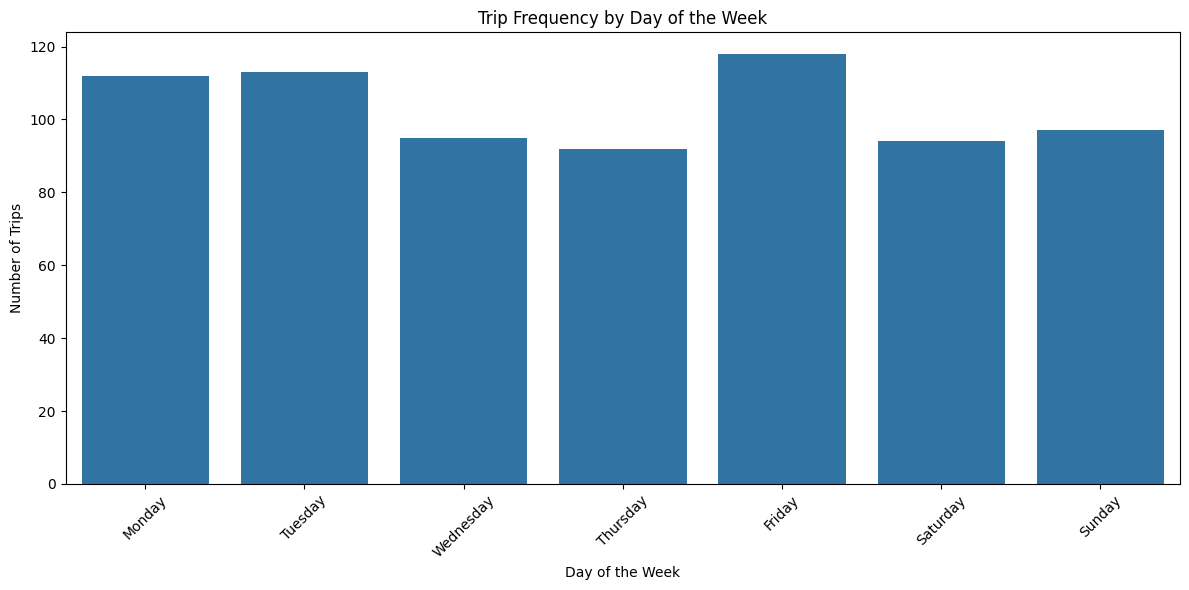

In [13]:
plt.figure(figsize=(12, 6))

# Trip Frequency by Day of the Week
sns.countplot(data=dataset, x='DAY', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Trip Frequency by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

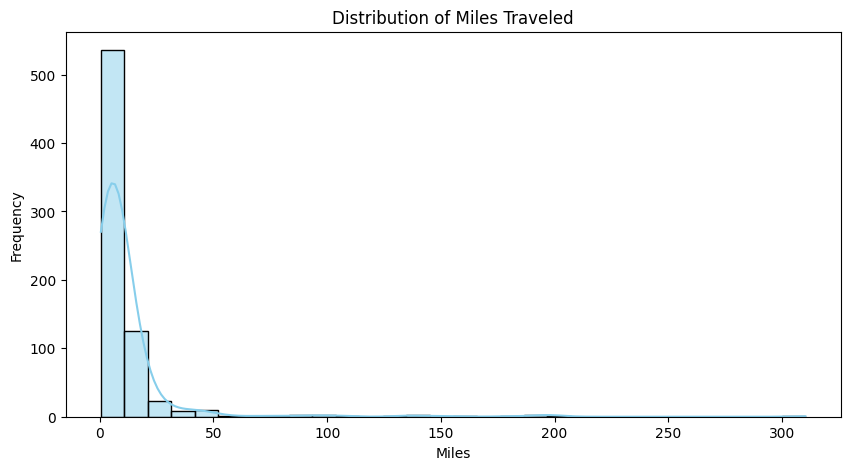

In [14]:
# Miles Distribution
plt.figure(figsize=(10, 5))
sns.histplot(dataset['MILES'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Miles Traveled')
plt.xlabel('Miles')
plt.ylabel('Frequency')
plt.show()

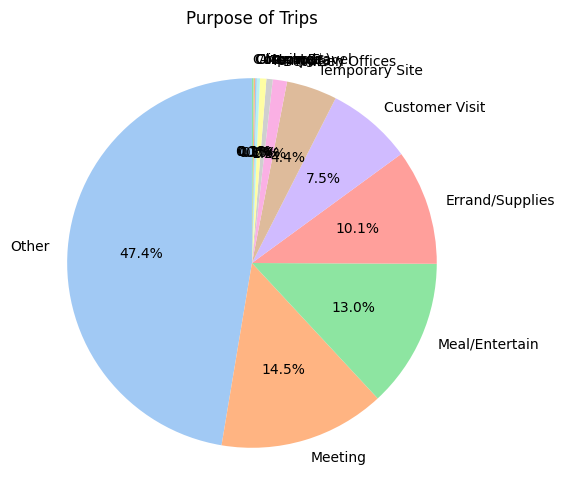

In [15]:
#Purpose of Trips
plt.figure(figsize=(12, 6))
dataset['PURPOSE'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Purpose of Trips')
plt.ylabel('')
plt.show()

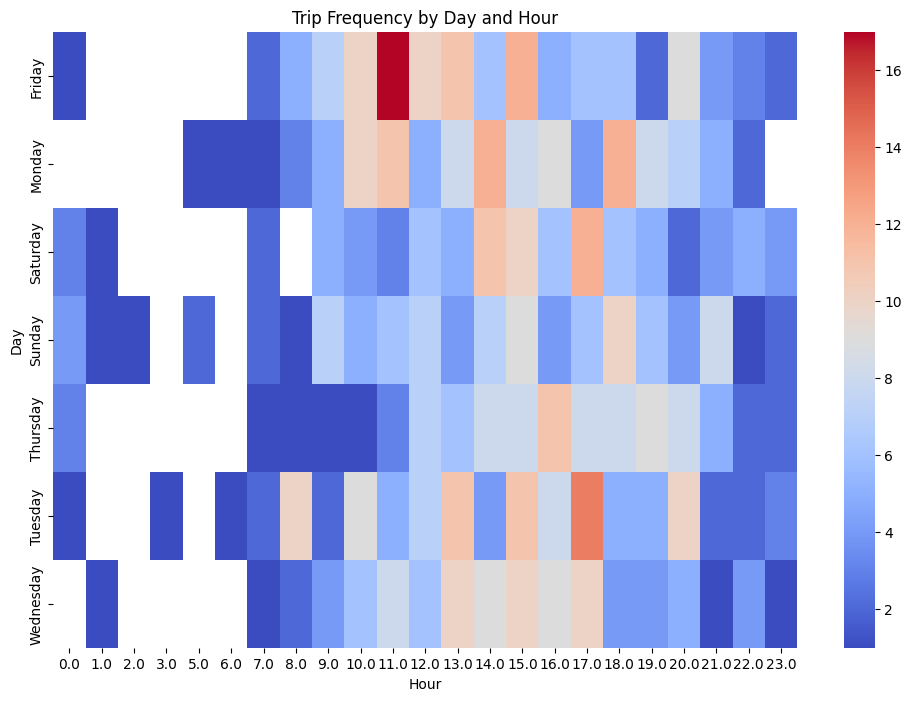

In [16]:
# Heatmap: Trip Frequency by Day and Hour
dataset['HOUR'] = dataset['START_DATE'].dt.hour
heatmap_data = dataset.groupby(['DAY', 'HOUR']).size().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False)
plt.title('Trip Frequency by Day and Hour')
plt.xlabel('Hour')
plt.ylabel('Day')
plt.show()

**GEOSPATIAL ANALYSIS**

In [17]:
# Simulating start and end coordinates (for demonstration purposes)
np.random.seed(42)
dataset['START_LAT'] = np.random.uniform(37.0, 38.0, len(dataset))
dataset['START_LONG'] = np.random.uniform(-122.5, -121.5, len(dataset))
dataset['END_LAT'] = np.random.uniform(37.0, 38.0, len(dataset))
dataset['END_LONG'] = np.random.uniform(-122.5, -121.5, len(dataset))

In [18]:
# Calculate actual travel distances using geodesic distances
dataset['ACTUAL_DISTANCE'] = dataset.apply(
    lambda row: geodesic((row['START_LAT'], row['START_LONG']), (row['END_LAT'], row['END_LONG'])).miles, axis=1)

**DATA AUGMENTATION**

In [19]:
# Simulate traffic conditions
np.random.seed(42)
traffic_conditions = np.random.choice(['Light', 'Moderate', 'Heavy'], size=len(dataset), p=[0.5, 0.3, 0.2])
dataset['TRAFFIC'] = traffic_conditions

In [20]:
# Adjust durations based on traffic
traffic_multiplier = {'Light': 1.0, 'Moderate': 1.2, 'Heavy': 1.5}
dataset['ADJUSTED_DURATION'] = dataset.apply(lambda row: row['DURATION_MINUTES'] * traffic_multiplier[row['TRAFFIC']], axis=1)

**COST ANALYSIS**

In [21]:
# Uber pricing model
base_fare = 2.5
cost_per_mile = 1.5
cost_per_minute = 0.25
dataset['ESTIMATED_COST'] = base_fare + (dataset['MILES'] * cost_per_mile) + (dataset['ADJUSTED_DURATION'] * cost_per_minute)

**PREDICTIVE ANALYSIS**

In [22]:
# Predicting trip category based on distance and duration
X = dataset[['ACTUAL_DISTANCE', 'DURATION_MINUTES']]
y = dataset['CATEGORY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [24]:
# Model evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

    Business       0.92      0.98      0.95       132
    Personal       0.33      0.08      0.12        13

    accuracy                           0.90       145
   macro avg       0.62      0.53      0.54       145
weighted avg       0.86      0.90      0.88       145

Confusion Matrix:
 [[130   2]
 [ 12   1]]


**SENTIMENT ANALYSIS**

In [25]:
# Simulating trip descriptions
dataset['TRIP_DESCRIPTION'] = np.random.choice([
    "Excellent service with friendly driver.",
    "Long and tiring journey.",
    "Smooth ride to my destination.",
    "The car was not clean.",
    "Driver was very helpful and polite."
], size=len(dataset))

In [26]:
# Perform sentiment analysis
def sentiment_label(text):
    positive_keywords = ['excellent', 'friendly', 'smooth', 'helpful', 'polite']
    negative_keywords = ['tiring', 'not clean']
    if any(word in text.lower() for word in positive_keywords):
        return 'Positive'
    elif any(word in text.lower() for word in negative_keywords):
        return 'Negative'
    else:
        return 'Neutral'

In [27]:
dataset['SENTIMENT'] = dataset['TRIP_DESCRIPTION'].apply(sentiment_label)

**DASHBOARD**

In [28]:
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Uber Data Analysis Dashboard", style={'textAlign': 'center'}),
    dcc.Tabs([
        dcc.Tab(label='Trip Statistics', children=[
            dcc.Graph(figure=px.bar(dataset, x='DAY', title='Trips by Day of the Week')),
            dcc.Graph(figure=px.pie(dataset, names='PURPOSE', title='Purpose of Trips')),
            dcc.Dropdown(
                id='day-filter',
                options=[{'label': day, 'value': day} for day in dataset['DAY'].unique()],
                placeholder='Select a Day',
            ),
            dcc.Graph(id='filtered-day-bar')
        ]),
        dcc.Tab(label='Time Series Analysis', children=[
            dcc.Graph(figure=px.line(x=dataset['START_DATE'], y=dataset['MILES'],
                                      title='Miles Traveled Over Time', labels={'x': 'Date', 'y': 'Miles'})),
            dcc.DatePickerRange(
                id='date-picker',
                start_date=dataset['START_DATE'].min(),
                end_date=dataset['START_DATE'].max()
            ),
            dcc.Graph(id='filtered-time-series')
        ]),
        dcc.Tab(label='Geospatial Analysis', children=[
            dcc.Graph(figure=px.scatter_mapbox(dataset, lat='START_LAT', lon='START_LONG',
                                              title='Trip Start Locations', mapbox_style='open-street-map'))
        ]),
        dcc.Tab(label='Cost Analysis', children=[
            dcc.Graph(figure=px.histogram(dataset, x='ESTIMATED_COST', nbins=30, title='Distribution of Estimated Costs')),
            dcc.Graph(figure=px.box(dataset, x='CATEGORY', y='ESTIMATED_COST',
                                    title='Cost Comparison by Trip Category', labels={'x': 'Category', 'y': 'Estimated Cost'}))
        ]),
        dcc.Tab(label='Traffic Analysis', children=[
            dcc.Graph(figure=px.bar(dataset, x='TRAFFIC', y='ADJUSTED_DURATION',
                                     title='Impact of Traffic on Trip Duration', labels={'x': 'Traffic Level', 'y': 'Adjusted Duration (Minutes)'}))
        ]),
        dcc.Tab(label='Sentiment Analysis', children=[
            dcc.Graph(figure=px.histogram(dataset, x='SENTIMENT',
                                          title='Sentiment Distribution for Trip Descriptions'))
        ]),
        dcc.Tab(label='Prediction Analysis', children=[
            dcc.Graph(figure=px.bar(x=['Short', 'Medium', 'Long'],
                                    y=[list(y_test).count('Short'), list(y_test).count('Medium'), list(y_test).count('Long')],
                                    title='Actual vs Predicted Categories'))
        ])
    ])
])


In [29]:
# Callbacks for interactivity
@app.callback(
    Output('filtered-day-bar', 'figure'),
    Input('day-filter', 'value')
)
def update_bar_chart(selected_day):
    if not selected_day:
        return px.bar(dataset, x='DAY', title='Trips by Day of the Week')
    filtered_data = dataset[dataset['DAY'] == selected_day]
    return px.bar(filtered_data, x='PURPOSE', title=f'Trip Purposes on {selected_day}')

@app.callback(
    Output('filtered-time-series', 'figure'),
    [Input('date-picker', 'start_date'), Input('date-picker', 'end_date')]
)
def update_time_series(start_date, end_date):
    filtered_data = dataset[(dataset['START_DATE'] >= start_date) & (dataset['START_DATE'] <= end_date)]
    return px.line(filtered_data, x='START_DATE', y='MILES', title='Filtered Miles Traveled Over Time')

**REPORT AND DASHBOARD**

In [30]:
class PDFReport(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Uber Data Analysis Report', 0, 1, 'C')
        self.ln(10)

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)

    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()

    def add_figure(self, figure_path):
        self.image(figure_path, x=10, w=190)
        self.ln(10)

In [31]:
# Generate PDF report
pdf = PDFReport()
pdf.add_page()
pdf.chapter_title('Overview')
pdf.chapter_body('This report provides an analysis of Uber trip data, including time series trends, geospatial insights, sentiment distribution, cost analysis, traffic impact, and prediction models.')
pdf.chapter_title('Key Insights')
pdf.chapter_body(f"Average Trip Cost: ${dataset['ESTIMATED_COST'].mean():.2f}\n")
pdf.chapter_body(f"Total Miles Traveled: {dataset['MILES'].sum():.2f} miles\n")
pdf.chapter_body(f"Total Trips: {len(dataset)}\n")

In [32]:
# Save the report
pdf.output("Uber_Data_Analysis_Report.pdf")

''

In [33]:
# Automatically open the dashboard
if __name__ == '__main__':
    webbrowser.open("http://127.0.0.1:8050/")
    app.run_server(debug=True, use_reloader=False)

<IPython.core.display.Javascript object>